In [1]:
#STEP: Processing the labels of the raw IMDB data

import os

imdb_dir = 'C:/Users/write/OneDrive/Deep Learning Data/aclImdb_project'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
reviews = []

#Note that 'reviews' will have neg reviews first so a random mixing would be required
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)  #In either '../train/neg' or in '../train/pos'
    for fname in os.listdir(dir_name):   #iterating on the files in 'neg' or 'pos' directory
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")  #opening .txt file in 'neg' or 'pos' directory
            reviews.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#print('Review texts:\n', texts)
#print('Labels:\n', labels)

In [2]:
#STEP: Tokenizing text of the IMDB data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 100    #Truncates reviews after 100 words
training_samples = 200   #Trains on 200 samples
validation_samples = 10000   #Validates on 10,000 samples
max_words = 10000   #Considers the top 10,000 words in the dataset

#*****************************************************************************************#
#This class allows to vectorize a text corpus by turning each text into either a sequence
#of integers (each integer being the index of a token in a dictionary) or into a vector where
#the coefficient for each token could be binary, based on word count, based on TF-IDF...
tokenizer = Tokenizer(num_words = max_words)
#*****************************************************************************************#

#*****************************************************************************************#
# fit_on_texts(texts) Updates internal vocabulary based on a list of texts.
#In the case where texts contain lists, we assume each entry of the lists to be a token.
#Required before using texts_to_sequences or texts_to_matrix
tokenizer.fit_on_texts(reviews) 
#*****************************************************************************************#

#*****************************************************************************************#
#Transforms each text in texts to a sequence of integers.
#Returns a list of sequences.
#Only top (num_words - 1) most frequent words will be taken into account.
#Only words known by the Toeknizer will be considered.
sequences = tokenizer.texts_to_sequences(reviews)
#*****************************************************************************************#

#*****************************************************************************************#
#word_index is a dictionary of words and their uniquely assigned integers
word_index = tokenizer.word_index
#*****************************************************************************************#
print('Found %s unique tokens.' % len(word_index))

D:\InstalledSoftware\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 72633 unique tokens.


In [3]:
#*****************************************************************************************#
#Pads sequences to the same length.
#This function transforms a list of num_samples sequences (lists of integers) 
#into a 2D Numpy array of shape  (num_samples, num_timesteps). 
#num_timesteps is either the maxlen argument if provided, 
#or the length of the longest sequence otherwise.
#Sequences that are shorter than num_timesteps are padded with value at the end.
#Sequences longer than num_timesteps are truncated so that they fit the desired length.
data = pad_sequences(sequences, maxlen = max_len)
#*****************************************************************************************#

print('Shape of data tensor: ', data.shape)   #(samples, size of each sample)
print(data.shape[0])  #number of samples

Shape of data tensor:  (17243, 100)
17243


In [4]:
labels = np.asarray(labels)
print('Shape of label tensor: ', labels.shape)  #(samples,)

Shape of label tensor:  (17243,)


In [5]:
#Splits the data into a training set and a validation set
#but first shuffles the data because we are starting with
#data in which samples are ordered (all negative first then all positives)
indices = np.arange(data.shape[0])
#print(indices)
np.random.shuffle(indices)
data = data[indices]
#print('\nShuffled data:\n', data)
labels = labels[indices]
#print('\nShuffled labels:\n', labels)

In [6]:
x_train = data[: training_samples]
y_train = labels[: training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

In [7]:
#STEP: Parsing the GloVe word-embedding file

glove_dir = 'C:/Users/write/OneDrive/DeepLearning Code/Natural Language Processing/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = "utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
#STEP: Preparing the GloVe word-embeddings matrix

#*****************************************************************************************#
#The network will learn 100 dimensional embeddings for each of the max_words (10000 in this case)
embedding_dim = 100
#*****************************************************************************************#
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  #Words not found in the embedding index will be all zeros

In [9]:
#STEP: Model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = max_len))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [10]:
#STEP: Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [11]:
#STEP: Training and Evaluation

from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer = optimizers.RMSprop(),
             loss = losses.binary_crossentropy,
             metrics = [metrics.binary_accuracy])

history_glv = model.fit(x_train, y_train,
                       epochs = 10,
                       batch_size = 32,
                       validation_data = (x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 1.1194 - binary_accuracy: 0.6700 - val_loss: 0.7942 - val_binary_accuracy: 0.7184
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3589 - binary_accuracy: 0.8400 - val_loss: 1.0311 - val_binary_accuracy: 0.2832
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3467 - binary_accuracy: 0.8100 - val_loss: 0.5993 - val_binary_accuracy: 0.7176
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1938 - binary_accuracy: 0.9300 - val_loss: 1.0447 - val_binary_accuracy: 0.7184
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1192 - binary_accuracy: 0.9750 - val_loss: 0.6915 - val_binary_accuracy: 0.5662
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0904 - binary_accuracy: 0.9850 - val_loss: 0.9017 - val_binary_accuracy: 0.7186
Epoch 7/10
200/2

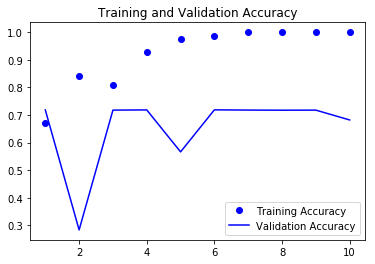

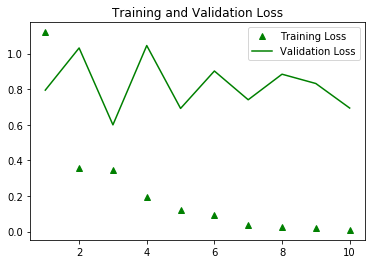

In [13]:
#STEP: Plotting pretrained model results

import matplotlib.pyplot as plt

acc = history_glv.history['binary_accuracy']
val_acc = history_glv.history['val_binary_accuracy']
loss = history_glv.history['loss']
val_loss = history_glv.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g^', label = 'Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()